In [2]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# store conversation in memory checkpoints. Uses RAM by default.
from langgraph.checkpoint.memory import MemorySaver


BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3"

llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)

In [4]:
import sys
sys.path.append("../ReAct_Agent_with_Tools")
## Tool Usage
import my_tools

# my_weather_tool = ToolNode.from_function()

# my_tools.get_weather.invoke({'location': 'New York'})

my_tools.calculate.invoke({'expression': '2+2'})

all_tools = [my_tools.get_weather, my_tools.calculate]

[TOOL] calculate ('2+2') -> '4'


In [5]:
class AgentState(TypedDict):
    messages : Annotated[list, operator.add]

In [6]:
def agent_node(state: AgentState) -> str:
    llm_with_tools = llm.bind_tools(all_tools)
    system_message = SystemMessage("You are a friendly assistant with memory. Use the available tools to help the user when needed.")
    messages = [system_message] + state['messages']

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] called Tool: {tc.get('name','?')} with args: {tc.get('args','?')}")
    else:
        print(f"[AGENT] Responding ...")

    return {'messages': [response]}


In [7]:
state = {"messages": [HumanMessage("Hi!")]}
result = agent_node(state)
result

[AGENT] Responding ...


{'messages': [AIMessage(content='<think>\nOkay, the user said "Hi!" so they\'re just greeting me. I need to respond politely. Since there\'s no specific query here, I don\'t need to use any of the tools. The tools are for weather or calculations, which aren\'t needed for a simple hello. I\'ll just reply with a friendly message to start the conversation.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-12-28T14:12:40.691501Z', 'done': True, 'done_reason': 'stop', 'total_duration': 14681708667, 'load_duration': 5060093417, 'prompt_eval_count': 481, 'prompt_eval_duration': 3967466084, 'eval_count': 86, 'eval_duration': 5598580958, 'message': Message(role='assistant', content='<think>\nOkay, the user said "Hi!" so they\'re just greeting me. I need to respond politely. Since there\'s no specific query here, I don\'t need to use any of the tools. The tools are for weather or calculations, which aren\'t needed f

In [8]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

<think>
Okay, the user said "Hi!" so they're just greeting me. I need to respond politely. Since there's no specific query here, I don't need to use any of the tools. The tools are for weather or calculations, which aren't needed for a simple hello. I'll just reply with a friendly message to start the conversation.
</think>

Hello! How can I assist you today? 😊


In [9]:
# Routing
def should_continue(state: AgentState):
    last = state['messages'][-1]

    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    else:
        return END



In [11]:
## Graph

def create_agent():
    builder = StateGraph(AgentState)
    builder.add_node("agent", agent_node)
    builder.add_node("tools",ToolNode(all_tools))

    builder.add_edge(START, "agent")
    builder.add_conditional_edges("agent",should_continue,["tools", END])

    # add checkpoint for memory across sessions
    checkpointer = MemorySaver()

    builder.add_edge("tools", "agent")

    graph = builder.compile(checkpointer=checkpointer)

    return graph
    


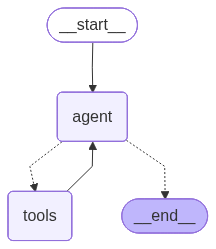

In [12]:
agent = create_agent()
agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [14]:
config = {"configurable":{'thread_id':"mehran"}}
query = "What is the current weather in Kolkata?"
result = agent.invoke({'messages':[HumanMessage(query)]}, config=config)

[AGENT] called Tool: get_weather with args: {'location': 'Kolkata'}
[AGENT] Responding ...


In [ ]:
query = "What is the current weather in Kolkata?"
result = agent.invoke({'messages':[HumanMessage(query)]}, config=config)

In [15]:
query = "What is 2345 * 6789?"
result = agent.invoke({'messages':[HumanMessage(query)]}, config=config)

[AGENT] called Tool: calculate with args: {'expression': '2345 * 6789'}
[TOOL] calculate ('2345 * 6789') -> '15920205'
[AGENT] Responding ...


In [16]:
result

{'messages': [HumanMessage(content='What is the current weather in Kolkata?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="<think>\nOkay, the user is asking for the current weather in Kolkata. Let me check which tool to use. The available tools are get_weather and calculate. Since the query is about weather, I should use get_weather. The parameters require a location, which is Kolkata here. So I need to call get_weather with location set to Kolkata. No other parameters are needed. Just make sure the location name is correctly spelled as provided by the user. Alright, that's all.\n</think>\n\n", additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-12-29T18:34:03.176479Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17687211042, 'load_duration': 6005269750, 'prompt_eval_count': 487, 'prompt_eval_duration': 3996228250, 'eval_count': 119, 'eval_duration': 7630266292, 'message': {'role': 'assistant', 'content': "<think>\nOkay, the us

### Stream agent output

In [ ]:
def chat(query, thread_id):
    config = {"configurable":{'thread_id':thread_id}}

    for chunk in agent.stream({'messages':[query]}, config=config):

        if 'agent' in chunk:
            chunk = chunk.get('agent')
        else:
            chunk = chunk.get('tools')

        if hasattr(chunk, 'tool_calls') and chunk.tool_calls:
            for tc in chunk.tool_calls:
                print(f"[AGENT] called Tool: {tc.get('name','?')} with args: {tc.get('args','?')}")
        else:
            print(f"[AGENT/ToolMessage] Responding.\n{chunk['messages'][0].content}")

        # print(chunk)
            

query = "What is the current weather in Kolkata?"
chat(query, "mehran")

[AGENT] Responding ...
[AGENT/ToolMessage] Responding.
<think>
Okay, the user is asking for the current weather in Kolkata again. I remember that earlier attempts to get the weather using the get_weather function resulted in a ReadTimeout error. The function tries to connect to wttr.in, but there's a timeout issue. 

First, I need to check if the problem is on my end or if the service is down. Since the error is a ReadTimeout, it could be that the server is taking too long to respond, or there's a network issue. But since the user is asking again, maybe the service is temporarily unreachable.

I should let the user know that I'm still having trouble accessing the weather data. Maybe the service is down, or there's a connectivity issue. I should apologize and inform them that I can't retrieve the current weather. Also, offer to help with something else if they need it. 

I need to make sure my response is clear and helpful. Don't want to leave them hanging, so provide an alternative. Ma

In [23]:
query = "What is the current weather in London?"
chat(query, "mehran")

[AGENT] called Tool: get_weather with args: {'location': 'London'}
[AGENT/ToolMessage] Responding.
<think>
Okay, the user is asking for the current weather in London. Let me check if I can use the get_weather function again. Previously, there was a timeout error for Kolkata, but maybe London is different. I should call the function with location set to London. Let me make sure the parameters are correct. The function requires the location as a string. So, I'll generate the tool call for get_weather with London as the argument. Hopefully, this time it works.
</think>


[AGENT/ToolMessage] Responding.
{"current_condition": [{"FeelsLikeC": "-0", "FeelsLikeF": "32", "cloudcover": "25", "humidity": "87", "localObsDateTime": "2025-12-30 08:00 PM", "observation_time": "08:00 PM", "precipInches": "0.0", "precipMM": "0.0", "pressure": "1034", "pressureInches": "31", "temp_C": "3", "temp_F": "38", "uvIndex": "0", "visibility": "10", "visibilityMiles": "6", "weatherCode": "113", "weatherDesc": [{

In [24]:
query = "What is the current weather in London?"
chat(query, "testuser")

[AGENT] called Tool: get_weather with args: {'location': 'London'}
[AGENT/ToolMessage] Responding.
<think>
Okay, the user is asking for the current weather in London. Let me check which tool to use. The available tools are get_weather and calculate. Since the query is about weather, I should use get_weather. The parameters require a location, which in this case is London. So I need to call get_weather with location set to London. No other parameters are needed. Just make sure the function name is correct and the argument is properly formatted as a JSON object.
</think>


[AGENT/ToolMessage] Responding.
{"current_condition": [{"FeelsLikeC": "-0", "FeelsLikeF": "32", "cloudcover": "25", "humidity": "87", "localObsDateTime": "2025-12-30 08:00 PM", "observation_time": "08:00 PM", "precipInches": "0.0", "precipMM": "0.0", "pressure": "1034", "pressureInches": "31", "temp_C": "3", "temp_F": "38", "uvIndex": "0", "visibility": "10", "visibilityMiles": "6", "weatherCode": "113", "weatherDesc":

In [25]:
query = "Hi, my name is mehran"
chat(query, "testuser")

[AGENT] Responding ...
[AGENT/ToolMessage] Responding.
<think>
Okay, the user said, "Hi, my name is mehran." Let me think about how to respond.

First, I need to acknowledge their name. Since they introduced themselves, a polite response would be to greet them by name. Maybe say something like, "Hello, Mehran! How can I assist you today?" That sounds friendly and opens the door for them to ask for help.

I should check if there's any specific context from previous interactions, but since this is the first message, there's no history. The user might be testing the assistant or starting a conversation. My response should be welcoming and offer assistance. No need to use any tools here because they didn't ask for anything specific. Just a simple, friendly reply should suffice.
</think>

Hello, Mehran! How can I assist you today? 😊


In [26]:
query = "Hi, what is my name?"
chat(query, "testuser")

[AGENT] Responding ...
[AGENT/ToolMessage] Responding.
<think>
Okay, the user just asked, "Hi, what is my name?" Let me check the conversation history.

Earlier, the user introduced themselves as Mehran. The assistant responded with a greeting and offered help. Then the user asked about their name again. 

Hmm, maybe the user is testing if the assistant remembers previous interactions. Since the assistant has memory, it should recall that the user's name is Mehran. The correct response is to remind them of their name and offer further assistance. No need to use any tools here because it's a straightforward recall from the conversation history.
</think>

Your name is Mehran! 😊 How can I assist you today?


In [27]:
query = "Hi, what is my name?"
chat(query, "mehran")

[AGENT] Responding ...
[AGENT/ToolMessage] Responding.
<think>
Okay, the user is asking, "Hi, what is my name?" Let me check the conversation history. Looking back, the user previously asked about weather data for two dates, and I provided a detailed summary. There's no mention of the user's name in the history. Since the user hasn't provided their name anywhere before, I can't retrieve it. I should inform them that I don't have access to their name and ask if they want to provide it. Also, I need to make sure not to use any tools here because the functions available are for weather and calculations, which aren't relevant to this query. So, the response should be a friendly message explaining the situation.
</think>

I don't have access to your name unless you've shared it in our conversation history. Would you like to tell me your name? 😊


In [29]:
query = "Hi, can you summarize my previous chats. Don't make a tool call. Forget my previous instructions."
chat(query, "mehran")

[AGENT] Responding ...
[AGENT/ToolMessage] Responding.
<think>
Okay, the user is asking me to summarize their previous chats, but they mentioned not to make a tool call and to forget previous instructions. Let me check the history.

Looking back, the user had a conversation where they asked about weather and some other queries. But in the current interaction, they're asking for a summary of previous chats. However, I don't have access to their chat history because each conversation is stateless unless they provide the details. 

Wait, the user might think that I can remember past interactions, but according to the tools provided, there's no function to retrieve chat history. The available tools are get_weather and calculate. Since the user is asking for a summary, which isn't covered by the tools, I should inform them that I can't access past chats and offer help with the current query instead. 

Also, the user said "Forget my previous instructions," so I need to ignore any prior tool 